In [21]:
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import norm
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from copulae1 import *
from KDEs import *
from toolbox import *
import warnings
import itertools
import os

warnings.filterwarnings("ignore")

data = pd.read_csv('../processed_data/btc_future_crix.csv')
data.head()

ecdf_brr = ECDF(data.return_brr)
ecdf_btc = ECDF(data.return_btc)

u = ecdf_brr(data.return_brr)
v = ecdf_btc(data.return_btc)

brr = np.array(data.return_brr)
btc = np.array(data.return_btc)

kde_brr = KDE(data.return_brr, "Gaussian")
kde_btc = KDE(data.return_btc, "Gaussian")

kde_brr = KDE(data.return_brr, "Gaussian", kde_brr.h_brot*3)
kde_btc = KDE(data.return_brr, "Gaussian", kde_btc.h_brot*3)

In [22]:
# Gaussian, t_Copula, Clayton, Frank, Gumbel, Plackett, Gaussian mix Indep
C1  = Gaussian(dict(rho=0.9),       Law_RS=kde_brr, Law_RF=kde_btc) # fix the maringals!
C2  = t_Copula(dict(rho=0.1, nu=4), Law_RS=kde_brr, Law_RF=kde_btc, nu_lowerbound=2) 
C2c = t_Copula(dict(rho=0.1, nu=4), Law_RS=kde_brr, Law_RF=kde_btc, nu_lowerbound=4) 
C3  = Clayton(dict(theta=0.1),      Law_RS=kde_brr, Law_RF=kde_btc)
C4  = Frank(dict(theta=0.1),        Law_RS=kde_brr, Law_RF=kde_btc)
C5  = Gumbel(dict(theta=3),         Law_RS=kde_brr, Law_RF=kde_btc)
C6  = Plackett(dict(theta=10),      Law_RS=kde_brr, Law_RF=kde_btc)
C7  = Gaussian_Mix_Independent(dict(rho=.9,p=0.7),Law_RS=kde_brr, Law_RF=kde_btc)
Copulae_names = ['Gaussian', 't_Copula', 't_Copula_Capped', 'Clayton', 'Frank', 'Gumbel', 'Plackett', 'Gauss Mix Indep']
Copulae_arr   = [C1,C2,C2c,C3,C4,C5,C6,C7]
Copulae = dict(zip(Copulae_names, Copulae_arr))

In [23]:
def ERM_estimate_trapezoidal(k, rh):
    rh = np.sort(rh)
    s  = ECDF(rh)(rh)
    d  = s[1:] - s[:-1] 
    toint = ERM_weight(k,s)*rh
    return -np.sum((toint[:-1] + toint[1:])*d)/2

def ES(q, rh):
    b = np.quantile(rh,q)
    return -np.mean(rh[rh<=q])

def wrapper(rs, rf, h, risk_measure):
    rh = rs - h*rf
    return risk_measure(rh)

def optimize_h(C, k_arr, q_arr):
    sample = C.sample(1000000)
    rs = sample[:,0]
    rf = sample[:,1]
    best_h = []
    
    for k in k_arr:
        fn = lambda h: wrapper(rs,rf,h,partial(ERM_estimate_trapezoidal,k))
        best_h.append(scipy.optimize.fmin(fn,1)[0])
        
    for q in q_arr:
        fn = lambda h: wrapper(rs,rf,h,partial(ES,q))
        best_h.append(scipy.optimize.fmin(fn,1)[0])
    return best_h

Optimization terminated successfully.
         Current function value: 0.007849
         Iterations: 11
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: -0.436606
         Iterations: 33
         Function evaluations: 67
Parameter by MM:  [0.83680664] Parameter by MLE:  [0.76821376]


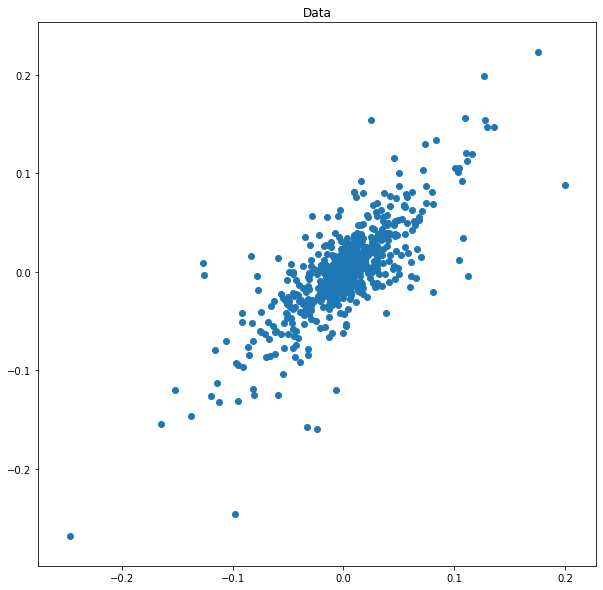

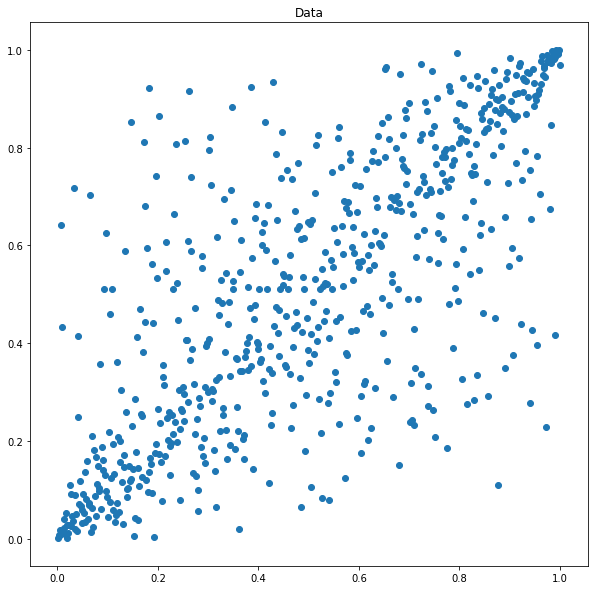

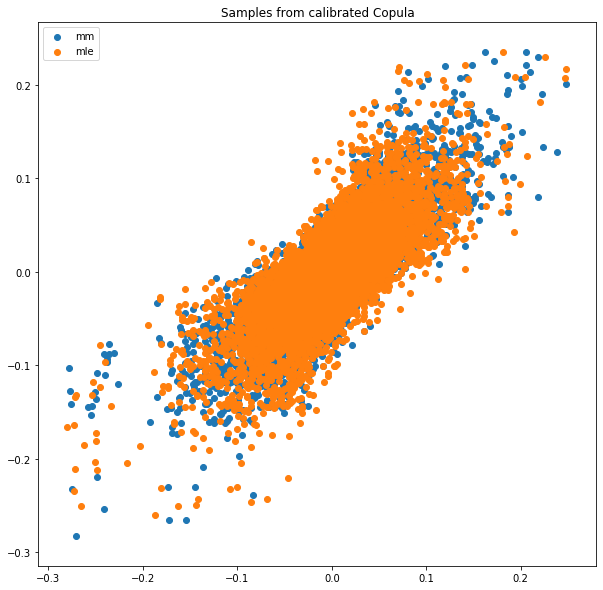

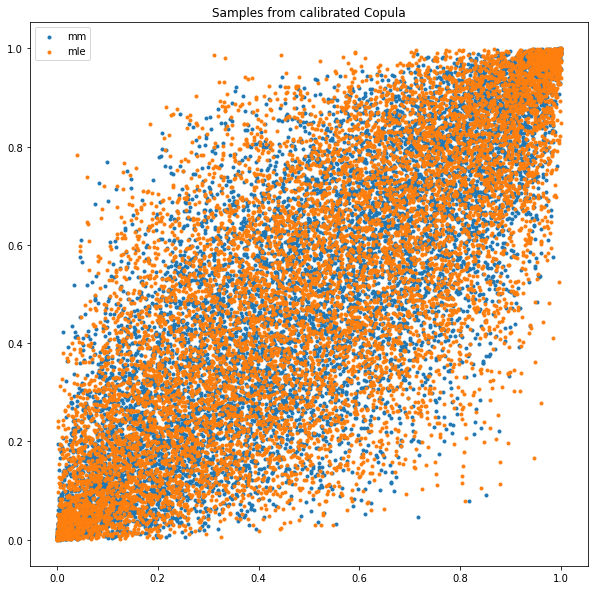

In [24]:
q_arr = [0.1,0.2,0.8,0.9]

def loss(rho):
    C1  = Gaussian({'rho':rho},       Law_RS=kde_brr, Law_RF=kde_btc) # fix the maringals!
    m = np.array([stats.kendalltau(u,v)[0]]+[empirical_lambda(u,v,q) for q in q_arr])
    m_hat = np.array([C1.tau()]+[C1._lambda(q) for q in q_arr])
    g = m-m_hat
    return g.dot(g.T)

para_mm = scipy.optimize.fmin(loss, 0.9)
C1_mm = Gaussian({'rho':para_mm},  Law_RS=kde_brr, Law_RF=kde_btc)

para_mle = C1.canonical_calibrate(u,v)
C1_mle = Gaussian({'rho':para_mle},  Law_RS=kde_brr, Law_RF=kde_btc)

def g(rho):
    C1  = Gaussian({'rho':rho},       Law_RS=kde_brr, Law_RF=kde_btc) # fix the maringals!
    m = np.array([stats.kendalltau(u,v)[0]]+[empirical_lambda(u,v,q) for q in q_arr])
    m_hat = np.array([C1.tau()]+[C1._lambda(q) for q in q_arr])
    g = m-m_hat
    return g

print("Parameter by MM: ",para_mm, "Parameter by MLE: ",para_mle)

s_mm  = C1_mm.sample(10000)
s_mle = C1_mle.sample(10000)

plt.figure(figsize=(10,10))
plt.title('Data')
plt.scatter(data.return_brr,data.return_btc)

plt.figure(figsize=(10,10))
plt.title('Data')
plt.scatter(u,v)

plt.figure(figsize=(10,10))
plt.title('Samples from calibrated Copula')
plt.scatter(s_mm[:,0],s_mm[:,1], label='mm')
plt.scatter(s_mle[:,0],s_mle[:,1], label='mle')
plt.legend()

plt.figure(figsize=(10,10))
plt.title('Samples from calibrated Copula')
plt.scatter(ECDF(s_mm[:,0])(s_mm[:,0]),ECDF(s_mm[:,1])(s_mm[:,1]), label='mm', marker='.')
plt.scatter(ECDF(s_mle[:,0])(s_mle[:,0]),ECDF(s_mle[:,1])(s_mle[:,1]), label='mle', marker='.')
plt.legend()

In [25]:
h1 = optimize_h(C1_mm, k_arr=[10, 20], q_arr=[0.1,0.05])
h2 = optimize_h(C1_mle, k_arr=[10, 20], q_arr=[0.1,0.05])
hs = pd.concat([pd.DataFrame(h1).T, pd.DataFrame(h2).T])
hs.index = ['MM', 'MLE']
hs.columns = ['ERM k=10', 'ERM k=20', 'ES q=0.1', 'ES q=0.05']
hs

Optimization terminated successfully.
         Current function value: 0.041152
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.052840
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000533
         Iterations: 14
         Function evaluations: 29
Optimization terminated successfully.
         Current function value: 0.002282
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.047933
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.061691
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000693
         Iterations: 13
         Function evaluations: 30
Optimization terminated successful

,ERM k=10,ERM k=20,ES q=0.1,ES q=0.05
MM,0.824512,0.849316,0.769434,0.805176
MLE,0.759961,0.792773,0.764062,0.712109


Optimization terminated successfully.
         Current function value: 0.003129
         Iterations: 48
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: -0.515522
         Iterations: 198
         Function evaluations: 383
Parameter by MM:  [0.78856314 1.78081183] Parameter by MLE:  [0.77581355 2.        ]


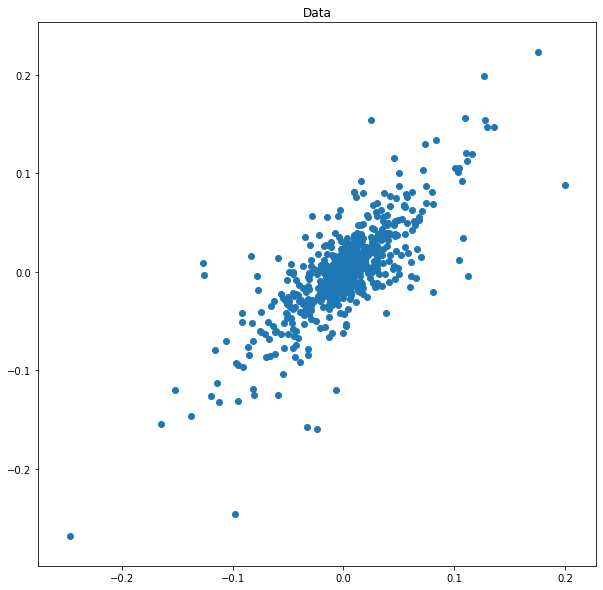

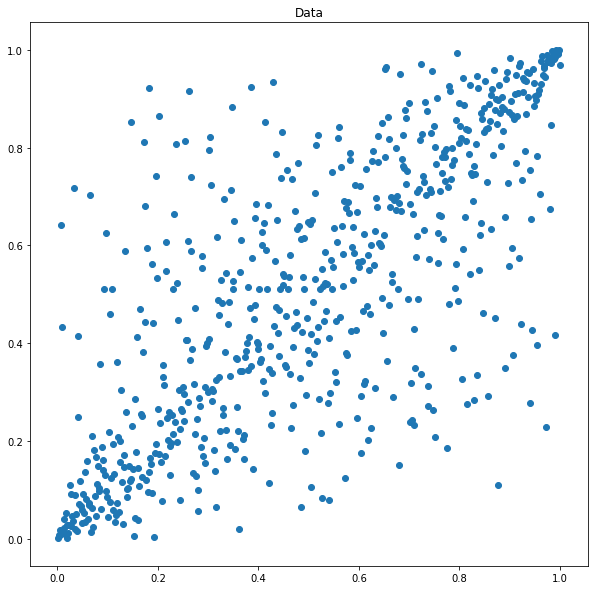

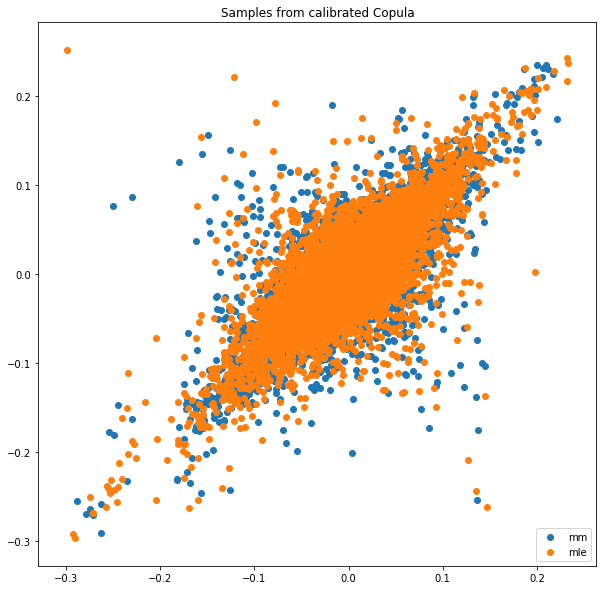

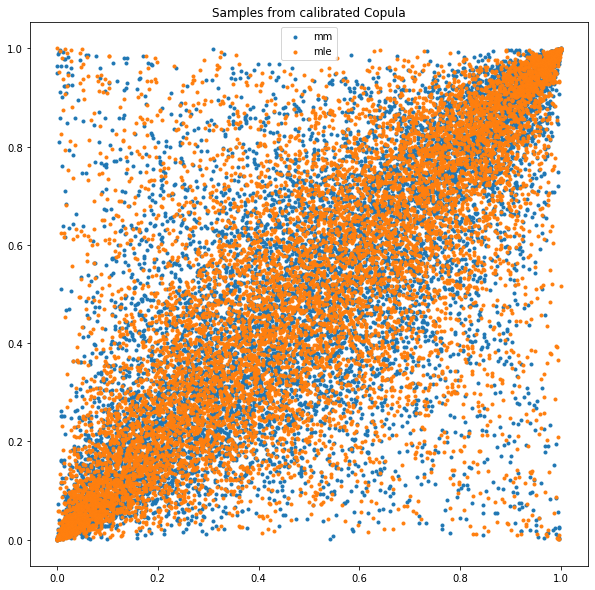

In [26]:
q_arr = [0.1,0.2,0.8,0.9]

def loss(paras):
    rho, nu = paras
    C1  = t_Copula({'rho':rho, 'nu':nu}, Law_RS=kde_brr, Law_RF=kde_btc, nu_lowerbound=2) # fix the maringals!
    m = np.array([stats.kendalltau(u,v)[0]]+[empirical_lambda(u,v,q) for q in q_arr])
    m_hat = np.array([C1.tau()]+[C1._lambda(q) for q in q_arr])
    g = m-m_hat
    return g.dot(g.T)

para_mm = scipy.optimize.fmin(loss, (0.9, 5))
C1_mm = t_Copula({'rho':para_mm[0], 'nu':para_mm[1]},  Law_RS=kde_brr, Law_RF=kde_btc,nu_lowerbound=2)

para_mle = C2.canonical_calibrate(u,v)
C1_mle = t_Copula({'rho':para_mm[0], 'nu':para_mm[1]},  Law_RS=kde_brr, Law_RF=kde_btc,nu_lowerbound=2)

def g(rho):
    C1  = Gaussian({'rho':rho},       Law_RS=kde_brr, Law_RF=kde_btc) # fix the maringals!
    m = np.array([stats.kendalltau(u,v)[0]]+[empirical_lambda(u,v,q) for q in q_arr])
    m_hat = np.array([C1.tau()]+[C1._lambda(q) for q in q_arr])
    g = m-m_hat
    return g

print("Parameter by MM: ",para_mm, "Parameter by MLE: ",para_mle)

s_mm  = C1_mm.sample(10000)
s_mle = C1_mle.sample(10000)

plt.figure(figsize=(10,10))
plt.title('Data')
plt.scatter(data.return_brr,data.return_btc)

plt.figure(figsize=(10,10))
plt.title('Data')
plt.scatter(u,v)

plt.figure(figsize=(10,10))
plt.title('Samples from calibrated Copula')
plt.scatter(s_mm[:,0],s_mm[:,1], label='mm')
plt.scatter(s_mle[:,0],s_mle[:,1], label='mle')
plt.legend()

plt.figure(figsize=(10,10))
plt.title('Samples from calibrated Copula')
plt.scatter(ECDF(s_mm[:,0])(s_mm[:,0]),ECDF(s_mm[:,1])(s_mm[:,1]), label='mm', marker='.')
plt.scatter(ECDF(s_mle[:,0])(s_mle[:,0]),ECDF(s_mle[:,1])(s_mle[:,1]), label='mle', marker='.')
plt.legend()

In [27]:
h1 = optimize_h(C1_mm, k_arr=[10, 20], q_arr=[0.1,0.05])
h2 = optimize_h(C1_mle, k_arr=[10, 20], q_arr=[0.1,0.05])
hs = pd.concat([pd.DataFrame(h1).T, pd.DataFrame(h2).T])
hs.index = ['MM', 'MLE']
hs.columns = ['ERM k=10', 'ERM k=20', 'ES q=0.1', 'ES q=0.05']
hs

Optimization terminated successfully.
         Current function value: 0.045874
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.062333
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000934
         Iterations: 17
         Function evaluations: 36
Optimization terminated successfully.
         Current function value: 0.003212
         Iterations: 14
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.045908
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.062369
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000931
         Iterations: 16
         Function evaluations: 34
Optimization terminated successful

,ERM k=10,ERM k=20,ES q=0.1,ES q=0.05
MM,0.787109,0.754492,0.525586,0.737012
MLE,0.788184,0.754687,0.529297,0.744727
